In [ ]:
import pandas as pd
from datetime import datetime
import time
import

In [ ]:
# Query to download the dataset (contains the stock prices data of 1 day minute wise from 2nd last week of July 2020)


# while True:
# ping = requests.get('https://query1.finance.yahoo.com/v8/finance/chart/%5ENSEI?range=3d&interval=1m').json()
# close = ping['chart']['result'][0]['indicators']['quote'][0]['close']
# timestamp = ping['chart']['result'][0]['timestamp']
# data_1 = pd.DataFrame({'Close': close, 'Time':timestamp})
# data_1['Time_b'] = [datetime.fromtimestamp(x) for x in data_1['Time']]
# data_1.drop('Time', axis=1,inplace=True)
# data_1.set_index('Time_b',inplace=True)

In [ ]:
# Check Google Colab system specs:


# !lscpu |grep 'Model name'
# !lscpu | grep 'Socket(s):'
# !lscpu | grep 'Core(s) per socket:'
# !lscpu | grep 'Thread(s) per core'
# !lscpu | grep "L3 cache" 
# !lscpu | grep "MHz"


In [ ]:
data_1=pd.read_csv('UBER_2.csv')


In [ ]:
print(len(data_1))
data_1=data_1.reset_index()
print(data_1.head())

390
   index               Time_b      Close
0      0  2020-07-22 13:30:00  32.490002
1      1  2020-07-22 13:31:00  32.639999
2      2  2020-07-22 13:32:00  32.669998
3      3  2020-07-22 13:33:00  32.799999
4      4  2020-07-22 13:34:00  32.610001


In [ ]:
import numpy as np
import pandas as pd
import io

Load the required files before proceeding further:

In [ ]:
df = data_1

In [ ]:
%tensorflow_version 1.x
import helpermethods
import tensorflow as tf
import numpy as np
import sys
import os
from tensorflow.keras.layers import Dense, Input, RNN
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

TensorFlow 1.x selected.


In [ ]:
print(tf.__version__)

1.15.2


In [ ]:
#Import keras grnn
from rnn import FastGRNNCellKeras, FastRNNCellKeras

Data Preprocessing

In [ ]:
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error 

In [ ]:
print(len(df))
df = df[df['Close'].notna()]
print(len(df))

390
389


In [ ]:
data = pd.DataFrame()
data['Close']=df['Close']

In [ ]:
count_nan = len(df) - df.count()
print(count_nan)

index     0
Time_b    0
Close     0
dtype: int64


## FastRNN

In [ ]:

#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
# training_data_len = math.ceil( len(dataset) *.6)
training_data_len = math.ceil( len(dataset)- 50) 



#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)


#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(10,len(train_data)):
    x_train.append(train_data[i-10:i,0])
    y_train.append(train_data[i,0])


#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)    


#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:

#Test data set
test_data = scaled_data[training_data_len - 10: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(10,len(test_data)):
    x_test.append(test_data[i-10:i,0])



#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [ ]:
# dataDimension = int(x_train.shape[1]) - 1
dataDimension = int(x_train.shape[1]) 
# print(dataDimension)

In [ ]:
cell = "FastRNN" 
 
inputDims = 10 #features taken in by RNN in one timestep
hiddenDims = 50 #hidden state of RNN
 
totalEpochs = 40
batchSize = 10
 
learningRate = 0.001 
decayStep = 50
decayRate = 0.1
 
outFile = None
 

wRank = None 
uRank = None 
 

sW = 1.0 
sU = 1.0
 
#Non-linearities for the RNN architecture. Can choose from "tanh, sigmoid, relu, quantTanh, quantSigm"
update_non_linearity = "relu"
gate_non_linearity = "relu"

In [ ]:
assert dataDimension % inputDims == 0, "Infeasible per step input, Timesteps have to be integer"


In [ ]:
cell == "FastRNN"
FastCell = FastRNNCellKeras(hiddenDims, #gate_non_linearity=gate_non_linearity,
                        update_non_linearity=update_non_linearity,
                        wRank=wRank, uRank=uRank)


In [ ]:
from tensorflow.keras import layers


In [ ]:
# print(tf.keras.__version__)

Create Model

In [ ]:
x = inputs = Input(shape=[int(dataDimension / inputDims), inputDims], name='input')
layer_shape = K.int_shape(x)#x.get_shape()
print(layer_shape)
x = RNN(FastCell, return_sequences=False, name='rnn')(x)
#x = RNN(FastCell_1, return_sequences=True, name='rnn1')(x)


out = Dense(1, activation='relu', name='dense')(x)
model = Model(inputs=inputs, outputs=out)
Adam_ = Adam(lr=0.001)
model.compile(optimizer=Adam_, loss='mean_squared_error', metrics=['accuracy'])

# model.summary()

(None, 1, 10)


In [ ]:
print(x_train.shape)
x_train = np.reshape(x_train,[x_train.shape[0],1,10])
print(x_test.shape)
x_test = np.reshape(x_test,[x_test.shape[0],1,10])
print(x_train.shape)
print(x_test.shape)

(329, 1, 10)
(50, 1, 10)
(329, 1, 10)
(50, 1, 10)


In [ ]:
import time
from keras.callbacks import CSVLogger

In [ ]:
csv_logger=0
csv_logger = CSVLogger("model_history_log_fastrnn.csv", append=False)


In [ ]:
start = time.time()
model.fit(x_train, y_train, batchSize, epochs=totalEpochs, validation_data=(x_test, scaled_data[training_data_len : , : ]), callbacks=[csv_logger])
stop = time.time()
print(f"Training time: {stop - start}s")

Train on 329 samples, validate on 50 samples
Epoch 1/40
329/329 [==============================] - 0s 232us/sample - loss: 0.0066 - acc: 0.0091 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 2/40
329/329 [==============================] - 0s 217us/sample - loss: 0.0065 - acc: 0.0091 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 3/40
329/329 [==============================] - 0s 223us/sample - loss: 0.0062 - acc: 0.0091 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 4/40
329/329 [==============================] - 0s 219us/sample - loss: 0.0061 - acc: 0.0091 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 5/40
329/329 [==============================] - 0s 216us/sample - loss: 0.0060 - acc: 0.0091 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 6/40
329/329 [==============================] - 0s 219us/sample - loss: 0.0060 - acc: 0.0091 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 7/40
329/329 [==============================] - 0s 215us/sample - loss: 0.0059 - acc: 0.0091 - val_loss: 0.00

In [ ]:
performance_log_fastrnn=pd.read_csv('model_history_log_fastrnn.csv')


In [ ]:
# print(performance_log_fastrnn)

In [ ]:
# print(performance_log_fastrnn)

In [ ]:
time_fastrnn= stop-start
print(time_fastrnn)

3.157587766647339


Finding MSE


In [ ]:
# Getting the models predicted price values
 
predictions_fastgrnn = model.predict(x_test)
predictions_fastgrnn = scaler.inverse_transform(predictions_fastgrnn)#Undo scaling

mse_fastgrnn= mean_squared_error(y_test, predictions_fastgrnn )
rmse_fastgrnn = math.sqrt(mse_fastgrnn)
print(rmse_fastgrnn)


0.024014036365424676


In [ ]:
from sklearn.metrics import r2_score

cod_fastrnn = r2_score(y_test, predictions_fastgrnn)
print(cod_fastrnn)

0.8786022649091301


## FB Prophet 

In [ ]:
from fbprophet import Prophet

In [ ]:
df_fb=df
print(len(df_fb))


389


In [ ]:
print(len(df_fb))

389


In [ ]:
df_fb['Time_b'] = pd.to_datetime(df_fb.Time_b,format='%Y-%m-%d')
df_fb.index = df_fb['Time_b']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#preparing data
df_fb.rename(columns={'Close': 'y', 'Time_b': 'ds'}, inplace=True)

#train and validation
train_fb = df_fb[:training_data_len]
valid_fb = df_fb[training_data_len:]

#fit the model
model_fb = Prophet(daily_seasonality=True)#,yearly_seasonality=True)


start_fb=time.time()
model_fb.fit(train_fb)
stop_fb = time.time()
print(f"Training time: {stop_fb - start_fb}s")



#predictions
close_prices_fb = model_fb.make_future_dataframe(periods=len(valid_fb), freq='1min')
forecast_fb = model_fb.predict(close_prices_fb)



/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Training time: 0.5428249835968018s


In [ ]:
time_fb=stop_fb-start_fb
print(time_fb)

0.5428249835968018


In [ ]:
#rmse
forecast_valid_fb = forecast_fb['yhat'][training_data_len:]

predictions_fb=np.array(forecast_valid_fb).reshape(-1,1)
rmse_fb=np.sqrt(np.mean(np.power((np.array(valid_fb['y'])-np.array(forecast_valid_fb)),2)))
print(rmse_fb)


0.064013151567721


In [ ]:

cod_fb = r2_score((valid_fb['y']), (forecast_valid_fb))
print(cod_fb)

0.13738168444070986


#####################################LSTM

In [ ]:
df = data_1
data_2 = df.filter(['Close'])
len(data_2)


data_2 = data_2[data_2['Close'].notna()]
len(data_2)

389

In [ ]:


#Converting the dataframe to a numpy array
dataset = data_2.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) -50) 
# training_data_len = math.ceil( len(dataset) *.6)




#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)


#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(10,len(train_data)):
    x_train.append(train_data[i-10:i,0])
    y_train.append(train_data[i,0])


#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)    


#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 10: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(10,len(test_data)):
    x_test.append(test_data[i-10:i,0])



#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

## LSTM(50 units)

In [ ]:

print(x_train.shape)
print(x_test.shape)



(329, 10, 1)
(50, 10, 1)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

In [ ]:


#Build the LSTM network model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=False,input_shape=(x_train.shape[1],1)))

model_lstm.add(Dense(units=1))


#Compile the model
model_lstm.compile(optimizer=Adam(lr=0.01), loss='mean_squared_error')


In [ ]:
csv_logger_lstm=0

In [ ]:
csv_logger_lstm = CSVLogger("model_history_log_lstm.csv", append=False)


In [ ]:
start_lstm = time.time()
 
#Train the model
model_lstm.fit(x_train, y_train, batch_size=10, epochs=40,validation_data=(x_test, scaled_data[training_data_len : , : ]),callbacks=[csv_logger_lstm]) 
 
stop_lstm = time.time()
print(f"Training time: {stop_lstm - start_lstm}s")

Train on 329 samples, validate on 50 samples
Epoch 1/40
329/329 [==============================] - 0s 568us/step - loss: 0.0039 - val_loss: 0.0017
Epoch 2/40
329/329 [==============================] - 0s 509us/step - loss: 0.0039 - val_loss: 0.0014
Epoch 3/40
329/329 [==============================] - 0s 564us/step - loss: 0.0038 - val_loss: 0.0030
Epoch 4/40
329/329 [==============================] - 0s 523us/step - loss: 0.0042 - val_loss: 0.0019
Epoch 5/40
329/329 [==============================] - 0s 538us/step - loss: 0.0038 - val_loss: 0.0021
Epoch 6/40
329/329 [==============================] - 0s 531us/step - loss: 0.0038 - val_loss: 0.0023
Epoch 7/40
329/329 [==============================] - 0s 602us/step - loss: 0.0037 - val_loss: 0.0014
Epoch 8/40
329/329 [==============================] - 0s 674us/step - loss: 0.0036 - val_loss: 0.0014
Epoch 9/40
329/329 [==============================] - 0s 564us/step - loss: 0.0037 - val_loss: 0.0016
Epoch 10/40
329/329 [================

In [ ]:
performance_log_lstm=pd.read_csv('model_history_log_lstm.csv')


In [ ]:
time_lstm_1=stop_lstm-start_lstm

In [ ]:
#Getting the models predicted price values
predictions_lstm = model_lstm.predict(x_test) 
predictions_lstm = scaler.inverse_transform(predictions_lstm)#Undo scaling

#Calculate/Get the value of RMSE
rmse_lstm_1=np.sqrt(np.mean(((predictions_lstm- y_test)**2)))
print(rmse_lstm_1)

0.022682774424281526


In [ ]:
cod_lstm_1 = r2_score(y_test, predictions_lstm)
print(cod_lstm_1)

0.8916889904266496


## LSTM(1 Unit)

In [ ]:


#Build the LSTM network model
model_lstm = Sequential()
model_lstm.add(LSTM(units=1, return_sequences=False,input_shape=(x_train.shape[1],1)))

model_lstm.add(Dense(units=1))


#Compile the model
model_lstm.compile(optimizer=Adam(lr=0.01), loss='mean_squared_error')

In [ ]:
from keras.callbacks import CSVLogger

In [ ]:
csv_logger_lstm_II=0
csv_logger_lstm_II = CSVLogger("model_history_log_lstm_II.csv", append=False)

In [ ]:
start_lstm = time.time()
 
#Train the model
model_lstm.fit(x_train, y_train, batch_size=10, epochs=40,validation_data=(x_test, scaled_data[training_data_len : , : ]),callbacks=[csv_logger_lstm_II]) 
 
stop_lstm = time.time()
print(f"Training time: {stop_lstm - start_lstm}s")

Train on 329 samples, validate on 50 samples
Epoch 1/40
329/329 [==============================] - 1s 2ms/step - loss: 0.2480 - val_loss: 0.0170
Epoch 2/40
329/329 [==============================] - 0s 430us/step - loss: 0.0496 - val_loss: 0.0345
Epoch 3/40
329/329 [==============================] - 0s 463us/step - loss: 0.0437 - val_loss: 0.0213
Epoch 4/40
329/329 [==============================] - 0s 486us/step - loss: 0.0367 - val_loss: 0.0183
Epoch 5/40
329/329 [==============================] - 0s 427us/step - loss: 0.0295 - val_loss: 0.0164
Epoch 6/40
329/329 [==============================] - 0s 438us/step - loss: 0.0225 - val_loss: 0.0092
Epoch 7/40
329/329 [==============================] - 0s 450us/step - loss: 0.0162 - val_loss: 0.0060
Epoch 8/40
329/329 [==============================] - 0s 445us/step - loss: 0.0117 - val_loss: 0.0034
Epoch 9/40
329/329 [==============================] - 0s 448us/step - loss: 0.0087 - val_loss: 0.0026
Epoch 10/40
329/329 [==================

In [ ]:
performance_log_lstm_II=pd.read_csv("model_history_log_lstm_II.csv")


In [ ]:
time_lstm_II=stop_lstm-start_lstm

In [ ]:
#Getting the models predicted price values
predictions_lstm_II = model_lstm.predict(x_test) 
predictions_lstm_II = scaler.inverse_transform(predictions_lstm_II)#Undo scaling

#Calculate/Get the value of RMSE
rmse_lstm_II=np.sqrt(np.mean(((predictions_lstm_II- y_test)**2)))
print(rmse_lstm_II)

0.022635819221926638


In [ ]:

cod_lstm_II = r2_score(y_test, predictions_lstm_II)
print(cod_lstm_II)

0.8921369516240896


In [ ]:

print(rmse_fastgrnn)
print(rmse_lstm_1)
print(rmse_lstm_II)
print(rmse_fb)

0.024014036365424676
0.022682774424281526
0.022635819221926638
0.064013151567721


##ARIMA




In [ ]:
###Testing for stationarity (Dickey-Fuller Test)
from statsmodels.tsa.stattools import adfuller
# test_result = adfuller(data['Close'])
#Ho: It is non stationary
#H1: It is stationary
 

def adfuller_test(sales):
    results = adfuller(sales)
    labels = ['ADF Test Statistic', 'p-value', '#Lags used', 'Number of observations used']
    for value, label in zip(results, labels):
        print (label + ' : ' + str(value))
    if (results[1] <= 0.05):
        print ("Strong evidence against Null Hypothesis-H0. Reject the Null Hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
data=data_1
# data = data[data['Close'].notna()]
data_to_se = data[data['Close'].notna()]

In [ ]:
data.head()

,index,Time_b,Close
0,0,2020-07-22 13:30:00,32.490002
1,1,2020-07-22 13:31:00,32.639999
2,2,2020-07-22 13:32:00,32.669998
3,3,2020-07-22 13:33:00,32.799999
4,4,2020-07-22 13:34:00,32.610001


In [ ]:
adfuller_test(data['Close'].dropna())

ADF Test Statistic : -2.3928921732865307
p-value : 0.14375259825627357
#Lags used : 4
Number of observations used : 384
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [ ]:
data['Close First Difference'] = data['Close'] - data['Close'].shift(1)
adfuller_test(data['Close First Difference'].dropna())

ADF Test Statistic : -4.928362023337243
p-value : 3.07020357611694e-05
#Lags used : 16
Number of observations used : 370
Strong evidence against Null Hypothesis-H0. Reject the Null Hypothesis. Data has no unit root and is stationary


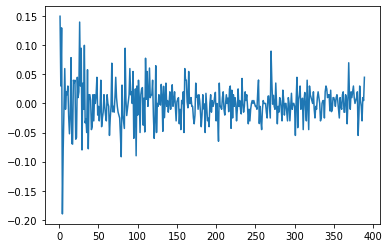

In [ ]:
data['Close First Difference'].dropna().plot()

In [ ]:
# data.to_csv(r"C:\Users\konark.yadav\Downloads\data.csv", index=False)
data['Seasonal Difference'] = data['Close'] - data['Close'].shift(12)

In [ ]:
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
import matplotlib.pyplot as plt
 
%matplotlib inline

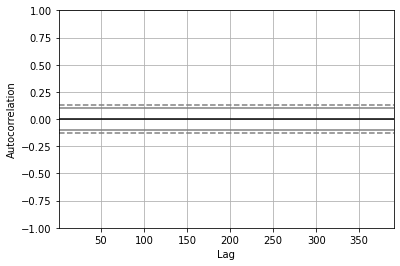

In [ ]:
# from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(data['Close'])
plt.show()

In [ ]:
adfuller_test(data['Seasonal Difference'].dropna())

ADF Test Statistic : -3.8746839389456627
p-value : 0.002229263908416324
#Lags used : 17
Number of observations used : 358
Strong evidence against Null Hypothesis-H0. Reject the Null Hypothesis. Data has no unit root and is stationary


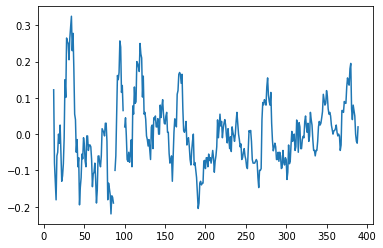

In [ ]:
data['Seasonal Difference'].plot()

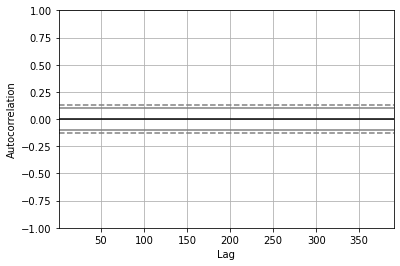

In [ ]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data['Close'])
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
X = data['Close'].dropna().values
size = int(len(X) -50)
train, test = X[0:size], X[size:len(X)]

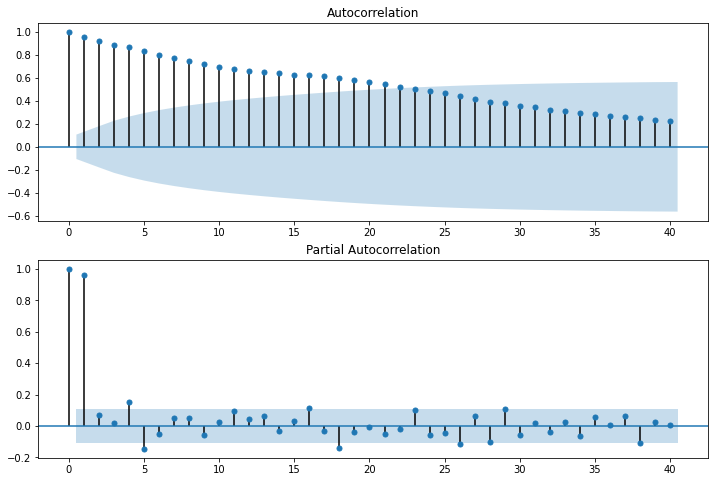

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
 
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train,lags=40,ax=ax2)

In [ ]:
# print(data)

In [ ]:
# train
start_arima = time.time()
model_arima = ARIMA(train, order = (2,1,1))
model_fit = model_arima.fit()
predictions=model_fit.forecast(len(test))[0]
stop_arima = time.time()

In [ ]:
len(test)

50

In [ ]:
from sklearn.metrics import mean_squared_error
error = math.sqrt(mean_squared_error(test, model_fit.forecast(len(test))[0]))
print('Test RMSE: %.3f' % error)

Test RMSE: 0.164


In [ ]:
time_arima=stop_arima - start_arima
print(time_arima)

0.28436970710754395


In [ ]:
from sklearn.metrics import r2_score
cod_arima = r2_score(test, predictions)
print(cod_arima)

-4.654129154918899


In [ ]:

print('Arima MSE: %.3f' % error)

print(rmse_fastgrnn)
print(rmse_lstm_1)
print(rmse_fb)


Arima MSE: 0.164
0.024014036365424676
0.022682774424281526
0.064013151567721


In [ ]:
print(time_lstm_1)
print(time_fastrnn)
print(time_fb)

7.488788604736328
3.157587766647339
0.5428249835968018


## CNN + BiLSTM

In [ ]:

df = data_1
data_2 = df.filter(['Close'])
len(data_2)

data_2 = data_2[data_2['Close'].notna()]
len(data_2)

389

In [ ]:
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
#Converting the dataframe to a numpy array
dataset = data_2.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) -50) 
# training_data_len = math.ceil( len(dataset) *.6)




#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)


#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(10,len(train_data)):
    x_train.append(train_data[i-10:i,0])
    y_train.append(train_data[i,0])


#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)    


#Reshape the data into the shape accepted by the CNN + BiLSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [ ]:
#Test data set
test_data = scaled_data[training_data_len - 10: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ]
for i in range(10,len(test_data)):
    x_test.append(test_data[i-10:i,0])


#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the CNN + BiLSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [ ]:
print(x_train.shape)
print(x_test.shape)

(329, 10, 1)
(50, 10, 1)


In [ ]:


from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
#Build the LSTM network model
model_cnn_lstm = Sequential()

model_cnn_lstm.add(Conv1D(filters=50, kernel_size=3, padding='same', activation='tanh',input_shape=(x_train.shape[1],1)))
model_cnn_lstm.add(Bidirectional(LSTM(units=50, return_sequences=False)))
model_cnn_lstm.add(Dropout(0.5))

# model_cnn_lstm.add(Dense(units=25))
model_cnn_lstm.add(Dense(units=1))


#Compile the model
model_cnn_lstm.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')

In [ ]:
csv_logger_cnn_lstm=0
csv_logger_cnn_lstm = CSVLogger("model_history_log_CNN_BiLSTM.csv", append=False)

In [ ]:
start_lstm = time.time()
 
#Train the model
model_cnn_lstm.fit(x_train, y_train, batch_size=10, epochs=40,validation_data=(x_test, scaled_data[training_data_len : , : ]),callbacks=[csv_logger_cnn_lstm]) 
 
stop_lstm = time.time()
print(f"Training time: {stop_lstm - start_lstm}s")

Train on 329 samples, validate on 50 samples
Epoch 1/40
329/329 [==============================] - 1s 4ms/step - loss: 0.0657 - val_loss: 0.0050
Epoch 2/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0231 - val_loss: 0.0041
Epoch 3/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0191 - val_loss: 0.0091
Epoch 4/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0164 - val_loss: 0.0045
Epoch 5/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0139 - val_loss: 0.0037
Epoch 6/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0135 - val_loss: 0.0055
Epoch 7/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0138 - val_loss: 0.0042
Epoch 8/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0120 - val_loss: 0.0038
Epoch 9/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 0.0040
Epoch 10/40
329/329 [==============================] - 

In [ ]:
performance_log_CNN_LSTM_BiLSTM=pd.read_csv("model_history_log_CNN_BiLSTM.csv")

In [ ]:
time_CNN_LSTM_BiLSTM= stop_lstm - start_lstm
print(time_CNN_LSTM_BiLSTM)

17.225104331970215


In [ ]:
#Getting the models predicted price values
predictions_CNN_LSTM_BiLSTM = model_cnn_lstm.predict(x_test) 
predictions_CNN_LSTM_BiLSTM = scaler.inverse_transform(predictions_CNN_LSTM_BiLSTM)#Undo scaling

#Calculate/Get the value of RMSE
rmse_CNN_LSTM_BiLSTM=np.sqrt(np.mean(((predictions_CNN_LSTM_BiLSTM- y_test)**2)))
print(rmse_CNN_LSTM_BiLSTM)

0.02144680405111002


In [ ]:
cod_CNN_LSTM_BiLSTM= r2_score(y_test, predictions_CNN_LSTM_BiLSTM)
print(cod_CNN_LSTM_BiLSTM)

0.9031710050592971


## FastRNN_CNN_BiLSTM (Proposed Model)

In [ ]:
import tensorflow.keras.layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from tensorflow.keras.layers import Dense, Input, RNN
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [ ]:
#Import keras grnn
from rnn import FastGRNNCellKeras, FastRNNCellKeras

In [ ]:


y = inputs = Input(shape=[int(dataDimension / inputDims), inputDims], name='input')
layer_shape = K.int_shape(y)#x.get_shape()

#Build the LSTM network model
y = RNN(FastCell, return_sequences=True, name='rnn')(y)
y= Conv1D(filters=300, kernel_size=3 , padding='same', activation='relu', name='Conv1D')(y)

y= MaxPooling1D(pool_size=1,name='MaxPooling1D')(y)

y= Bidirectional(LSTM(units=50, return_sequences=False))(y)

out= Dense(units=1)(y)
model_fastrnn_hyb = Model(inputs=inputs, outputs=out)

model_fastrnn_hyb.compile(optimizer=Adam_, loss='mean_squared_error')


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
print(x_train.shape)
x_train = np.reshape(x_train,[x_train.shape[0],1,10])
print(x_test.shape)
x_test = np.reshape(x_test,[x_test.shape[0],1,10])
print(x_train.shape)
print(x_test.shape)

(329, 10, 1)
(50, 10, 1)
(329, 1, 10)
(50, 1, 10)


In [ ]:
csv_logger_fast_hybrid = CSVLogger("model_history_log_fast_hybrid.csv", append=False)


In [ ]:
start = time.time()
model_fastrnn_hyb.fit(x_train, y_train, batchSize, epochs=totalEpochs, validation_data=(x_test, scaled_data[training_data_len : , : ]),callbacks=[csv_logger_fast_hybrid])
stop = time.time()
print(f"Training time: {stop - start}s")

Train on 329 samples, validate on 50 samples
Epoch 1/40
329/329 [==============================] - 0s 875us/sample - loss: 0.0037 - val_loss: 0.0017
Epoch 2/40
329/329 [==============================] - 0s 919us/sample - loss: 0.0037 - val_loss: 0.0017
Epoch 3/40
329/329 [==============================] - 0s 942us/sample - loss: 0.0038 - val_loss: 0.0018
Epoch 4/40
329/329 [==============================] - 0s 898us/sample - loss: 0.0040 - val_loss: 0.0016
Epoch 5/40
329/329 [==============================] - 0s 833us/sample - loss: 0.0042 - val_loss: 0.0017
Epoch 6/40
329/329 [==============================] - 0s 885us/sample - loss: 0.0036 - val_loss: 0.0018
Epoch 7/40
329/329 [==============================] - 0s 840us/sample - loss: 0.0040 - val_loss: 0.0018
Epoch 8/40
329/329 [==============================] - 0s 811us/sample - loss: 0.0043 - val_loss: 0.0018
Epoch 9/40
329/329 [==============================] - 0s 878us/sample - loss: 0.0039 - val_loss: 0.0016
Epoch 10/40
329/329

In [ ]:
performance_log_fast_hybrid=pd.read_csv('model_history_log_fast_hybrid.csv')


In [ ]:
time_fastrnn_hyb_CNN_BiLSTM= stop - start
print(time_fastrnn_hyb_CNN_BiLSTM)

11.7472562789917


In [ ]:
#Getting the models predicted price values
predictions_fastrnn_hyb_CNN_BiLSTM = model_fastrnn_hyb.predict(x_test) 
predictions_fastrnn_hyb_CNN_BiLSTM = scaler.inverse_transform(predictions_fastrnn_hyb_CNN_BiLSTM)#Undo scaling

#Calculate/Get the value of RMSE
rmse_fastrnn_hyb_CNN_BiLSTM=np.sqrt(np.mean(((predictions_fastrnn_hyb_CNN_BiLSTM- y_test)**2)))
print(rmse_fastrnn_hyb_CNN_BiLSTM)

0.021336595916915876


In [ ]:
cod_fastrnn_hyb_CNN_BiLSTM = r2_score(y_test, predictions_fastrnn_hyb_CNN_BiLSTM) 
print(cod_fastrnn_hyb_CNN_BiLSTM)

0.9041635934717165


In [ ]:
print(rmse_fastgrnn)
print(rmse_CNN_LSTM_BiLSTM)
print(rmse_lstm_1)
print(rmse_lstm_II)

0.024014036365424676
0.02144680405111002
0.022682774424281526
0.022635819221926638


## LSTM + Attention (RELU)

In [ ]:

import os
import re

import numpy as np
import pandas as pd
import tensorflow as tf
import keras.backend as K
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.layers import *
from keras.models import Model


In [ ]:
df = data_1
data_2 = df.filter(['Close'])
len(data_2)

data_2 = data_2[data_2['Close'].notna()]
len(data_2)

import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
#Converting the dataframe to a numpy array
dataset = data_2.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) -50) 
# training_data_len = math.ceil( len(dataset) *.6)




#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)


#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(10,len(train_data)):
    x_train.append(train_data[i-10:i,0])
    y_train.append(train_data[i,0])


#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)    


#Reshape the data into the shape accepted by the CNN + Attention + BiLSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

#Test data set
test_data = scaled_data[training_data_len - 10: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(10,len(test_data)):
    x_test.append(test_data[i-10:i,0])



#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the CNN + Attention + BiLSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [ ]:
# pip install keras-self-attention

In [ ]:
import keras
from keras_self_attention import SeqSelfAttention

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D


from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints
from keras.layers import Flatten, LSTM

#Build the LSTM network model
model_cnn_lstm = Sequential()
model_cnn_lstm.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model_cnn_lstm.add(SeqSelfAttention(attention_activation='relu'))


model_cnn_lstm.add(Flatten())
model_cnn_lstm.add(Dense(units=1))


#Compile the model
model_cnn_lstm.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
    


In [ ]:
model_cnn_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 10, 50)            10400     
_________________________________________________________________
seq_self_attention_1 (SeqSel (None, 10, 50)            3265      
_________________________________________________________________
flatten_1 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 501       
Total params: 14,166
Trainable params: 14,166
Non-trainable params: 0
_________________________________________________________________


In [ ]:
csv_logger_CNN_BiLSTM_Attention_Mechanism=0
csv_logger_CNN_BiLSTM_Attention_Mechanism = CSVLogger("model_history_log_CNN_BiLSTM_Attention_Mechanism.csv", append=False)

In [ ]:
start_lstm = time.time()
 
#Train the model
model_cnn_lstm.fit(x_train, y_train, batch_size=10, epochs=40,validation_data=(x_test, scaled_data[training_data_len : , : ]),callbacks=[csv_logger_CNN_BiLSTM_Attention_Mechanism]) 
 
stop_lstm = time.time()
print(f"Training time: {stop_lstm - start_lstm}s")
time_CNN_BiLSTM_Attention_Mechanism= stop_lstm-start_lstm

Train on 329 samples, validate on 50 samples
Epoch 1/40
329/329 [==============================] - 1s 4ms/step - loss: 0.0575 - val_loss: 0.0077
Epoch 2/40
329/329 [==============================] - 0s 760us/step - loss: 0.0167 - val_loss: 0.0075
Epoch 3/40
329/329 [==============================] - 0s 716us/step - loss: 0.0155 - val_loss: 0.0107
Epoch 4/40
329/329 [==============================] - 0s 743us/step - loss: 0.0164 - val_loss: 0.0103
Epoch 5/40
329/329 [==============================] - 0s 730us/step - loss: 0.0162 - val_loss: 0.0080
Epoch 6/40
329/329 [==============================] - 0s 760us/step - loss: 0.0152 - val_loss: 0.0072
Epoch 7/40
329/329 [==============================] - 0s 720us/step - loss: 0.0149 - val_loss: 0.0087
Epoch 8/40
329/329 [==============================] - 0s 802us/step - loss: 0.0152 - val_loss: 0.0100
Epoch 9/40
329/329 [==============================] - 0s 883us/step - loss: 0.0156 - val_loss: 0.0065
Epoch 10/40
329/329 [==================

In [ ]:

performance_log_CNN_BiLSTM_Attention_Mechanism=pd.read_csv("model_history_log_CNN_BiLSTM_Attention_Mechanism.csv")


In [ ]:
#Getting the models predicted price values
predictions_CNN_BiLSTM_Attention_Mechanism = model_cnn_lstm.predict(x_test) 
predictions_CNN_BiLSTM_Attention_Mechanism = scaler.inverse_transform(predictions_CNN_BiLSTM_Attention_Mechanism)#Undo scaling

#Calculate/Get the value of RMSE
rmse_CNN_BiLSTM_Attention_Mechanism=np.sqrt(np.mean(((predictions_CNN_BiLSTM_Attention_Mechanism- y_test)**2)))
print(rmse_CNN_BiLSTM_Attention_Mechanism)

0.027881618478358506


In [ ]:
cod_CNN_BiLSTM_Attention_Mechanism = r2_score(y_test, predictions_CNN_BiLSTM_Attention_Mechanism) 
print(cod_CNN_BiLSTM_Attention_Mechanism)

0.8363499220013866


In [ ]:
# preprocessing

In [ ]:
df = data_1
data_2 = df.filter(['Close'])
len(data_2)

data_2 = data_2[data_2['Close'].notna()]
len(data_2)

import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
#Converting the dataframe to a numpy array
dataset = data_2.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) -50) 
# training_data_len = math.ceil( len(dataset) *.6)




#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)


#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(10,len(train_data)):
    x_train.append(train_data[i-10:i,0])
    y_train.append(train_data[i,0])


#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)    


#Reshape the data into the shape accepted by the CNN + Attention + BiLSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

#Test data set
test_data = scaled_data[training_data_len - 10: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(10,len(test_data)):
    x_test.append(test_data[i-10:i,0])



#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the CNN + Attention + BiLSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [ ]:
x_train.shape[1],1

(10, 1)

## LSTM+CNN

In [ ]:

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
ip = x_train[1].shape

model_new_cnn_lstm = Sequential()
model_new_cnn_lstm.add(LSTM(units=50, return_sequences=True,input_shape=ip))
model_new_cnn_lstm.add(Conv1D(filters=50, kernel_size=3, padding='same', activation='relu'))
model_new_cnn_lstm.add(MaxPooling1D(pool_size=2))


model_new_cnn_lstm.add(Flatten())
model_new_cnn_lstm.add(Dense(units=25))
model_new_cnn_lstm.add(Dense(units=1))

#Compile the model
model_new_cnn_lstm.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')

In [ ]:
# model_new_cnn_lstm.summary()

In [ ]:
csv_logger_new_cnn_lstm=0
csv_logger_new_cnn_lstm = CSVLogger("model_history_log_new_cnn_lstm.csv", append=False)

In [ ]:
start_lstm = time.time()
 
#Train the model
model_new_cnn_lstm.fit(x_train, y_train, batch_size=10, epochs=40,validation_data=(x_test, scaled_data[training_data_len : , : ]),callbacks=[csv_logger_new_cnn_lstm]) 
 
stop_lstm = time.time()
print(f"Training time: {stop_lstm - start_lstm}s")
time_model_new_cnn_lstm= stop_lstm-start_lstm

Train on 329 samples, validate on 50 samples
Epoch 1/40
329/329 [==============================] - 1s 4ms/step - loss: 0.0379 - val_loss: 0.0043
Epoch 2/40
329/329 [==============================] - 0s 688us/step - loss: 0.0129 - val_loss: 0.0046
Epoch 3/40
329/329 [==============================] - 0s 677us/step - loss: 0.0115 - val_loss: 0.0042
Epoch 4/40
329/329 [==============================] - 0s 774us/step - loss: 0.0096 - val_loss: 0.0029
Epoch 5/40
329/329 [==============================] - 0s 713us/step - loss: 0.0078 - val_loss: 0.0044
Epoch 6/40
329/329 [==============================] - 0s 717us/step - loss: 0.0070 - val_loss: 0.0024
Epoch 7/40
329/329 [==============================] - 0s 746us/step - loss: 0.0066 - val_loss: 0.0022
Epoch 8/40
329/329 [==============================] - 0s 700us/step - loss: 0.0064 - val_loss: 0.0025
Epoch 9/40
329/329 [==============================] - 0s 692us/step - loss: 0.0056 - val_loss: 0.0023
Epoch 10/40
329/329 [==================

In [ ]:
performance_log_lstm_II=pd.read_csv("model_history_log_new_cnn_lstm.csv")

In [ ]:
#Getting the models predicted price values
predictions_model_new_cnn_lstm = model_new_cnn_lstm.predict(x_test) 
predictions_model_new_cnn_lstm = scaler.inverse_transform(predictions_model_new_cnn_lstm)#Undo scaling

#Calculate/Get the value of RMSE
rmse_model_new_cnn_lstm=np.sqrt(np.mean(((predictions_model_new_cnn_lstm- y_test)**2)))
print(rmse_model_new_cnn_lstm)

0.03000193583160201


In [ ]:
cod_model_new_cnn_lstm = r2_score(y_test, predictions_model_new_cnn_lstm) 
print(cod_model_new_cnn_lstm)

0.8105132652847815


In [ ]:
print(rmse_fastrnn_hyb_CNN_BiLSTM)
print(rmse_CNN_LSTM_BiLSTM)
print(rmse_lstm_1)
print(rmse_lstm_II)

0.021336595916915876
0.02144680405111002
0.022682774424281526
0.022635819221926638


## Dense + [Conv1D + MaxPooling1D]*2 + LSTM*2 + Dense*2

In [ ]:
ip = x_train[1].shape
model_cnn_lstm = Sequential()
model_cnn_lstm.add(Dense(units=128))
model_cnn_lstm.add(Conv1D(filters=112, kernel_size=1, padding='same', activation='relu',input_shape=(x_train.shape[1],1)))
model_cnn_lstm.add(MaxPooling1D(pool_size=2))
model_cnn_lstm.add(Conv1D(filters=64, kernel_size=1, padding='same', activation='relu'))
model_cnn_lstm.add(MaxPooling1D(pool_size=1))

model_cnn_lstm.add(LSTM(units=128, return_sequences=True))
model_cnn_lstm.add(LSTM(units=32, return_sequences=False))

model_cnn_lstm.add(Dense(units=100))
model_cnn_lstm.add(Dense(units=1))

model_cnn_lstm.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')

In [ ]:
csv_logger_hybrid=0
csv_logger_hybrid = CSVLogger("model_history_log_hybrid.csv", append=False)

In [ ]:
start_lstm = time.time()
 
#Train the model
model_cnn_lstm.fit(x_train, y_train, batch_size=10, epochs=40,validation_data=(x_test, scaled_data[training_data_len : , : ]),callbacks=[csv_logger_hybrid]) 
 
stop_lstm = time.time()
print(f"Training time: {stop_lstm - start_lstm}s")
time_model_hybrid= stop_lstm-start_lstm

Train on 329 samples, validate on 50 samples
Epoch 1/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 2/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 3/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 4/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 5/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0024
Epoch 6/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 7/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 8/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 9/40
329/329 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0024
Epoch 10/40
329/329 [==============================] - 

In [ ]:
performance_log_hybrid=pd.read_csv("model_history_log_hybrid.csv")

In [ ]:
#Getting the models predicted price values
predictions_model_hybrid = model_cnn_lstm.predict(x_test) 
predictions_model_hybrid = scaler.inverse_transform(predictions_model_hybrid)#Undo scaling

#Calculate/Get the value of RMSE
rmse_model_hybrid=np.sqrt(np.mean(((predictions_model_hybrid - y_test)**2)))
print(rmse_model_hybrid)

0.0257786166779353


In [ ]:
cod_model_hybrid = r2_score(y_test, predictions_model_hybrid) 
print(cod_model_hybrid)

0.8601058758193674


In [ ]:
print(rmse_fastrnn_hyb_CNN_BiLSTM)
print(rmse_CNN_LSTM_BiLSTM)
print(rmse_lstm_1)
print(rmse_lstm_II)

0.021336595916915876
0.02144680405111002
0.022682774424281526
0.022635819221926638


## Save the data

In [ ]:
df_final = pd.DataFrame(columns=['Variabel_name','RMSE','Time(in sec)','Description','R-Square value'])

In [ ]:
df_final.loc[0] = pd.Series({'Variabel_name': str('FastRNN'),'RMSE':rmse_fastgrnn ,'Time(in sec)':time_fastrnn,'Description':str('-'),'R-Square value': cod_fastrnn})
df_final.loc[1] = pd.Series({'Variabel_name': str('LSTM (50 Units)'),'RMSE':rmse_lstm_1 ,'Time(in sec)':time_lstm_1,'Description':str('-'),'R-Square value':cod_lstm_1})
df_final.loc[2] = pd.Series({'Variabel_name': str('LSTM (1 Unit)'),'RMSE':rmse_lstm_II ,'Time(in sec)':time_lstm_II,'Description':str('-'),'R-Square value':cod_lstm_II})
df_final.loc[3] = pd.Series({'Variabel_name': str('Arima'),'RMSE':error ,'Time(in sec)':str('-'),'Description':str('-'),'R-Square value':cod_arima})
df_final.loc[4] = pd.Series({'Variabel_name': str('FB_Prophet'),'RMSE':rmse_fb ,'Time(in sec)':time_fb,'Description':str('-'),'R-Square value':cod_fb})

df_final.loc[5] = pd.Series({'Variabel_name': str('CNN_BiLSTM'),'RMSE':rmse_CNN_LSTM_BiLSTM ,'Time(in sec)':time_CNN_LSTM_BiLSTM,'Description':str('conv1d + maxpooling + biLSTM + Dropout + dense'),'R-Square value':cod_CNN_LSTM_BiLSTM})
df_final.loc[6] = pd.Series({'Variabel_name': str('FASTRNN_CNN_BiLSTM'),'RMSE':rmse_fastrnn_hyb_CNN_BiLSTM ,'Time(in sec)':time_fastrnn_hyb_CNN_BiLSTM,'Description':str('FastCell + cov1D + Maxpooling(unit=1) + BiLSTM + dropout + dense + dense'),'R-Square value':cod_fastrnn_hyb_CNN_BiLSTM})

df_final.loc[7] = pd.Series({'Variabel_name': str('LSTM_Attention_(ReLU)'),'RMSE':rmse_CNN_LSTM_BiLSTM ,'Time(in sec)':time_CNN_LSTM_BiLSTM,'Description':str('Conv1d + BiLSTM + Dropout + [Dense]*2'),'R-Square value':cod_CNN_LSTM_BiLSTM})
df_final.loc[8] = pd.Series({'Variabel_name': str('LSTM_CNN'),'RMSE':rmse_model_new_cnn_lstm ,'Time(in sec)':time_model_new_cnn_lstm,'Description':str('LSTM + Conv1d + MaxPooling + Flatten + [Dense]*2'),'R-Square value':cod_model_new_cnn_lstm})
df_final.loc[9] = pd.Series({'Variabel_name': str('CNN_2_LSTM_2'),'RMSE':rmse_model_hybrid ,'Time(in sec)':time_model_hybrid,'Description':str('Dense + [Conv1D + MaxPooling1D]*2 + LSTM*2 + Dense*2'),'R-Square value':cod_model_hybrid})



In [ ]:
print(df_final)
df_final.to_csv('Apple_performance_results.csv', index=False)

           Variabel_name  ...  R-Square value
0                FastRNN  ...        0.878602
1        LSTM (50 Units)  ...        0.891689
2          LSTM (1 Unit)  ...        0.892137
3                  Arima  ...       -4.654129
4             FB_Prophet  ...        0.137382
5             CNN_BiLSTM  ...        0.903171
6     FASTRNN_CNN_BiLSTM  ...        0.904164
7  LSTM_Attention_(ReLU)  ...        0.903171
8               LSTM_CNN  ...        0.810513
9           CNN_2_LSTM_2  ...        0.860106

[10 rows x 5 columns]


In [ ]:
df_final

,Variabel_name,RMSE,Time(in sec),Description,R-Square value
0,FastRNN,0.024014,3.15759,-,0.878602
1,LSTM (50 Units),0.022683,7.48879,-,0.891689
2,LSTM (1 Unit),0.022636,6.90582,-,0.892137
3,Arima,0.163886,-,-,-4.654129
4,FB_Prophet,0.064013,0.542825,-,0.137382
5,CNN_BiLSTM,0.021447,17.2251,conv1d + maxpooling + biLSTM + Dropout + dense,0.903171
6,FASTRNN_CNN_BiLSTM,0.021337,11.7473,FastCell + cov1D + Maxpooling(unit=1) + BiLSTM...,0.904164
7,LSTM_Attention_(ReLU),0.021447,17.2251,Conv1d + BiLSTM + Dropout + [Dense]*2,0.903171
8,LSTM_CNN,0.030002,12.5301,LSTM + Conv1d + MaxPooling + Flatten + [Dense]*2,0.810513
9,CNN_2_LSTM_2,0.025779,17.8949,Dense + [Conv1D + MaxPooling1D]*2 + LSTM*2 + D...,0.860106


# New Section

In [ ]:
predicted_results = pd.DataFrame(columns=['Test_Data','FastRNN'  ,'LSTM (50 Units)','LSTM (1 Unit)'  ,'Arima'  ,'FB_Prophet'  ,'CNN_BiLSTM'  ,'FASTRNN_CNN_BiLSTM'  ,'LSTM_Attention_(ReLU)', 'LSTM_CNN','CNN_2_LSTM_2' ])

In [ ]:
predicted_results['Test_Data']=np.squeeze(y_test)
predicted_results['FastRNN']=np.squeeze(predictions_fastgrnn)
predicted_results['LSTM (50 Units)']=np.squeeze(predictions_lstm)
predicted_results['LSTM (1 Unit)']=np.squeeze(predictions_lstm_II)
predicted_results['Arima']=np.squeeze(predictions)
predicted_results['FB_Prophet']=np.squeeze(predictions_fb)
predicted_results['CNN_BiLSTM']  =np.squeeze(predictions_CNN_LSTM_BiLSTM)

predicted_results['FASTRNN_CNN_BiLSTM']=np.squeeze(predictions_fastrnn_hyb_CNN_BiLSTM)
predicted_results['LSTM_Attention_(ReLU)']  =np.squeeze(predictions_CNN_LSTM_BiLSTM)

predicted_results['LSTM_CNN']  =np.squeeze(predictions_model_new_cnn_lstm)
predicted_results['CNN_2_LSTM_2']=np.squeeze(predictions_model_hybrid)




In [ ]:
predicted_results.head()

,Test_Data,FastRNN,LSTM (50 Units),LSTM (1 Unit),Arima,FB_Prophet,CNN_BiLSTM,FASTRNN_CNN_BiLSTM,LSTM_Attention_(ReLU),LSTM_CNN,CNN_2_LSTM_2
0,32.419998,32.385895,32.393467,32.404980,32.390190,32.411060,32.395115,32.401352,32.395115,32.399288,32.422371
1,32.445000,32.403740,32.406414,32.419922,32.391153,32.413037,32.414597,32.417400,32.414597,32.410378,32.424957
2,32.455002,32.425957,32.434425,32.436607,32.391975,32.415211,32.438618,32.436649,32.438618,32.424660,32.442646
3,32.470001,32.445213,32.452415,32.447422,32.392705,32.417585,32.456219,32.453968,32.456219,32.436092,32.464439
4,32.485001,32.464470,32.470631,32.460136,32.393347,32.420163,32.472778,32.474476,32.472778,32.452953,32.481274


In [ ]:
predicted_results.to_csv('Predicted_Values.csv', index=False)